Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

/tmp/ipykernel_102/3363813471.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [2]:
URL = "http://bit.ly/2IgDF0E"
df_voles = pd.read_csv(URL)
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

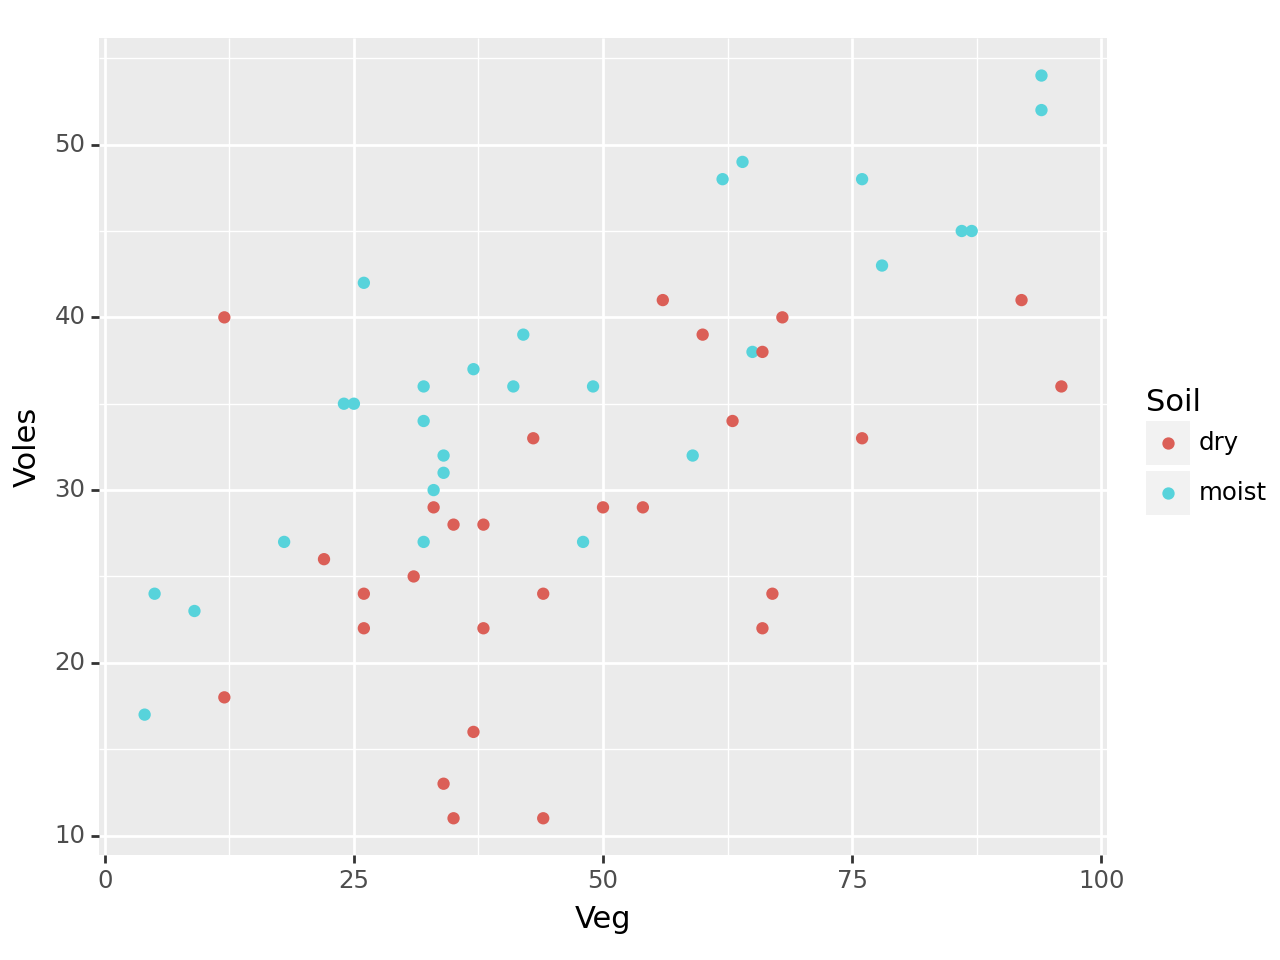

In [3]:
plot =(ggplot(df_voles, aes(x='veg', y='voles', color='soil')) + geom_point() +
        labs(x= "Veg", y = "Voles", color = "Soil"))
print(plot)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [4]:
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ['soil']), 
    remainder='passthrough')
pipeline = make_pipeline(
    column_transformer,
    LinearRegression())
X = df_voles[['soil', 'veg']]
y = df_voles['voles']
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

## For the parallel slope model. 

In [5]:
predictions = pipeline.predict(X)
df_pred = pd.DataFrame(predictions, columns=['Predicted_Voles'])
df_pred.head()

,Predicted_Voles
0,25.600600
1,33.113599
2,48.916804
3,41.144736
4,32.854530


In [6]:
df_voles1 = df_voles.assign(voles_predicted = predictions)
df_voles1.head()

,site,voles,veg,soil,voles_predicted
0,1,17,4,moist,25.600600
1,2,30,33,moist,33.113599
2,3,54,94,moist,48.916804
3,4,49,64,moist,41.144736
4,5,34,32,moist,32.854530


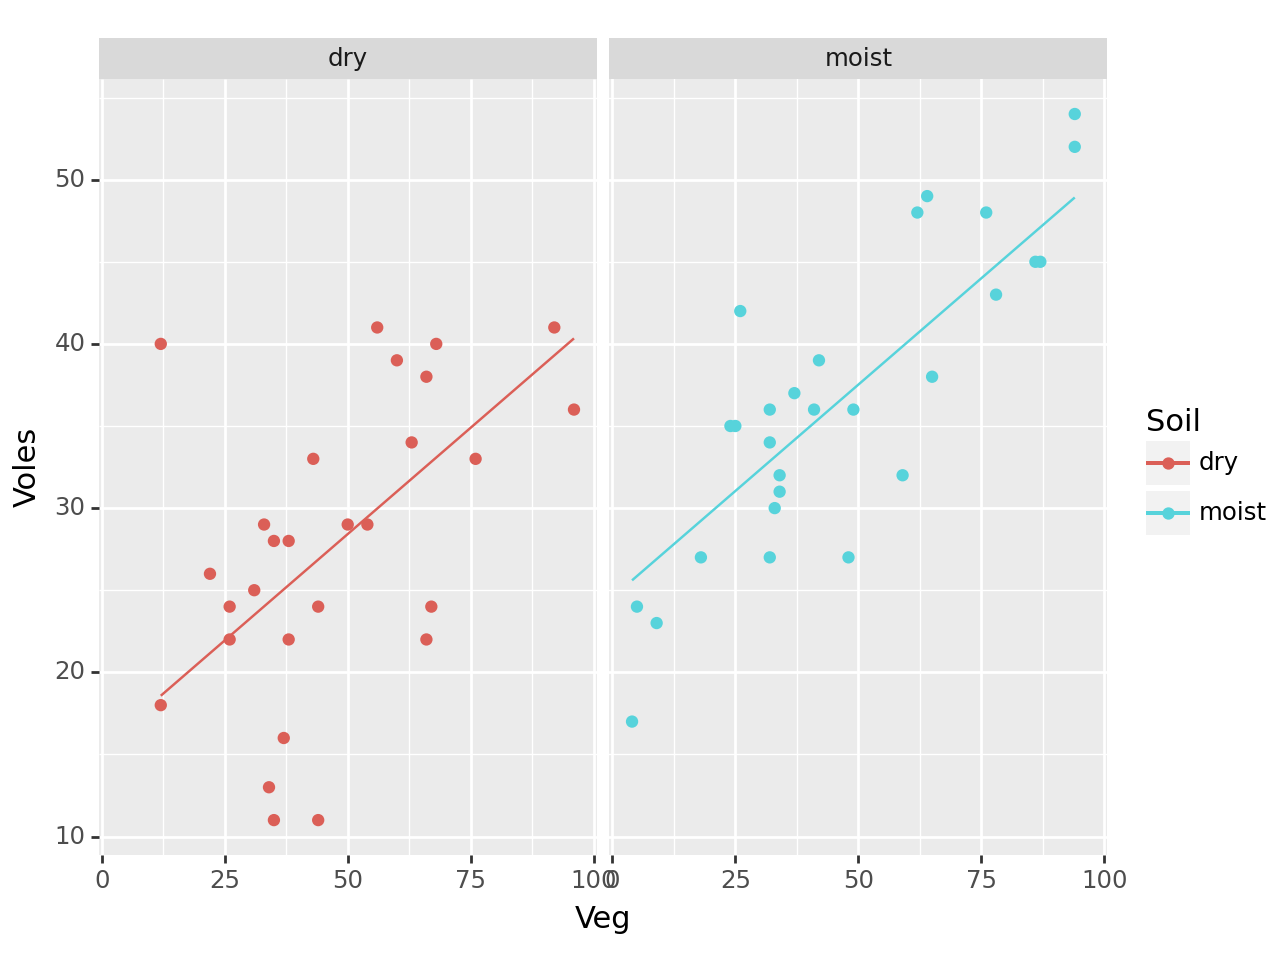

In [7]:
# Scatter plot for the parallel-slope model
plot_1 = (ggplot(df_voles1, aes(x='veg', y='voles', color='soil')) +
        geom_point(aes(color='soil')) +
        geom_line(aes(color='soil', y='voles_predicted')) +
        labs(x='Veg', y='Voles', color='Soil') +
        facet_wrap('~ soil'))

print(plot_1)

In [8]:
# regression table for the parallel slope model.
def get_regression_table(pipeline):
    pl = pipeline
    terms = list(pl['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pl['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

regression_table = get_regression_table(pipeline)
print(regression_table)

                        term   estimate
0  onehotencoder__soil_moist   9.100298
1             remainder__veg   0.259069
2                  intercept  15.464026


* **Slope is 0.26, which means that for every 1% increase in vegetation cover, there is an increase of 0.26 in the vole poulation.** 
* **y-int for moist soil is 24.56, which means that when there is no vegetation cover in the moist soil, the vole poulation is about 25.**
* **y-int for dry soil is 15.5, which means that when there is no vegetation cover in the dry soil, the vole poulation is about 16.**

❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer: I used the parallel slopes model here. Yes, protecting a site with high vegetation cover seems like a more effective way to preserve the vole population, because there is a positive correlation between the percent cover of vegetation at each site and the vole count on each site. From the scatter plot, the the vole count increases as the percent cover of vegetation increases.**

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer: Approximately a vegetation cover of 56% needs to be maintained to support a vole poulation of about 30 on the dry site.**

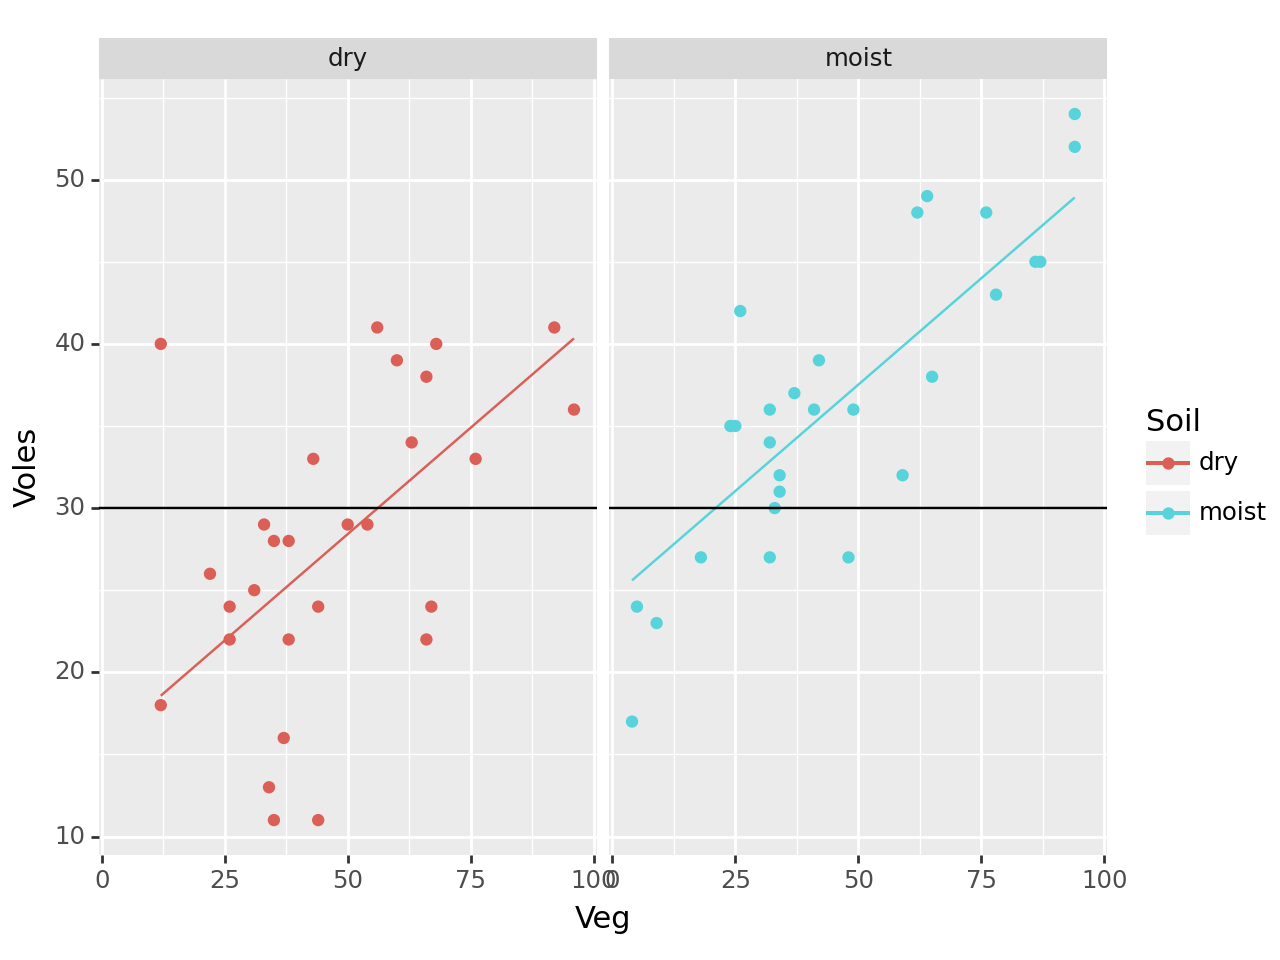

In [9]:
plot_2 = (ggplot(df_voles1, aes(x='veg', y='voles', color='soil')) +
        geom_point(aes(color='soil')) +
        geom_line(aes(color='soil', y='voles_predicted')) +
        labs(x='Veg', y='Voles', color='Soil') +
        facet_wrap('~ soil') + 
        geom_hline(yintercept=30, linetype='solid', color='black'))
       
print(plot_2)

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer: 34.92708151. For a 40% vegetation cover, in a moist soil, the population of voles will be approximately 35.**

In [10]:
predicted_population = pipeline.predict( pd.DataFrame({"soil": ["moist"], "veg": [40]}))
print("Predicted vole population:", predicted_population)

Predicted vole population: [34.92708151]
